# iterative image reconstruction from radon transform

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image

from scipy.ndimage.interpolation import rotate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## utils

In [2]:
def sinogram(matrix, anumber = 18, amin = 0, amax = 180):
    N1, N2 = matrix.shape
    s = np.zeros((anumber, N2))
    thetas = np.linspace(amax*(1 - 1/anumber), amin, anumber)
    for e, theta in enumerate(thetas):
        rot = rotate(matrix, theta, reshape = False)
        s[e] = np.sum(rot, axis = 0)
    return s

In [3]:
def normalize(value):
    '''
    normalizes channel of image
    '''
    minimum = value.min()
    maximum = value.max()
    return (value - minimum)/(maximum - minimum)

def clamp(value, a=0, b=1):
    '''
    clamp values
    '''
    copy = value.copy()
    copy[copy < a] = a
    copy[copy > b] = b
    return copy

def normalizeAll(image):
    '''
    normalizes all channels of image
    '''
    image = image.copy()
    image[:,:,0] = normalize(image[:,:,0])
    image[:,:,1] = normalize(image[:,:,1])
    image[:,:,2] = normalize(image[:,:,2])
    return image

def rOrder(N, seed = 1):
    np.random.seed(seed)
    order = np.arange(N)
    np.random.shuffle(order)
    return order

### input image

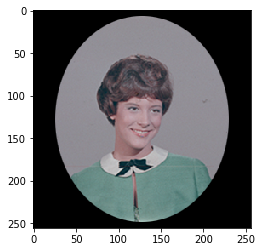

In [4]:
x = Image.open('input/woman02.png')
x = np.asarray(x)/255

a = Image.open('input/mask_t.png')
a = np.asarray(a)/255

x = x*a
# N1 => y axis
# N2 => x axis
N1, N2, _ = x.shape

### split channels ###
r, g, b = x[:,:,0], x[:,:,1], x[:,:,2]

plt.imshow(x)
plt.show()

# radon transform

In [5]:
anumber = N1*2
amin = 0
amax = 360

sr = sinogram(r, anumber, amin, amax)
sg = sinogram(g, anumber, amin, amax)
sb = sinogram(b, anumber, amin, amax)

### display radon transform ###
t = np.zeros((anumber, N2, 3))
Rd, Gd, Bd = t*0, t*0, t*0
Rd[:,:,0] = normalize(sr)
Gd[:,:,1] = normalize(sg)
Bd[:,:,2] = normalize(sb)

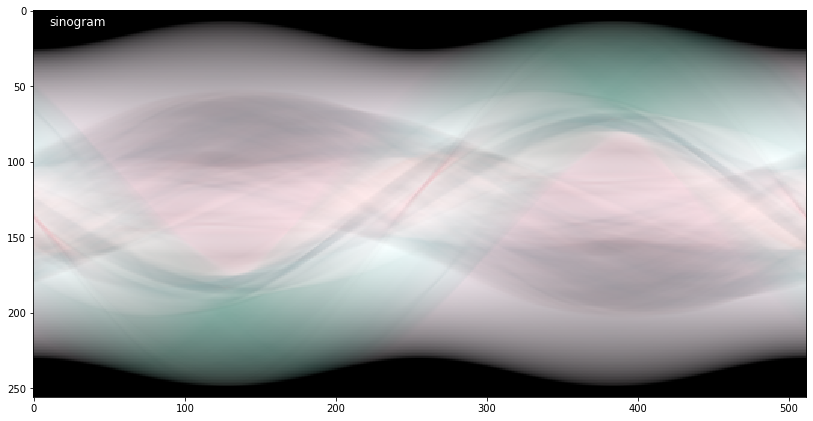

In [6]:
plt.figure(figsize = (1024/72, 512/72))

rotated = rotate(Rd + Gd + Bd, 90)
rotated = (rotated - rotated.min())/(rotated.max() - rotated.min())
plt.imshow(rotated)

plt.text(10, 10, 'sinogram', color = 'white', size = 12)
plt.show()

# reconstruction visualization

In [7]:
theta = np.linspace(amin, amax*(1 - 1/anumber), anumber)
n = np.arange(N2)/N2
ramlak = np.abs(0.5 - n)*2

### init visualization ###
rd, gd, bd, out = x*0, x*0, x*0, x*0

### sequence attributes ###
frame = 0
padding = int(np.log10(2*anumber)) + 1

### sinogram padding
padImg = ((0, 0), ((anumber - N2)//2, (anumber - N2)//2), (0, 0))

### unfiltered backprojection

In [8]:
rOr = rOrder(anumber, 123)
rOg = rOrder(anumber, 234)
rOb = rOrder(anumber, 345)
for nr, ng, nb in zip(rOr, rOg, rOb):
    ### init plot ###
    fig = plt.figure(figsize = (1000/72, 600/72))
    gs = gridspec.GridSpec(3, 5)
    gs.update(left = 0, right = 1, bottom = 0, top = 1, wspace = 0, hspace = 0)
    axAr = plt.subplot(gs[0, 0]); axAr.axis('off')
    axAg = plt.subplot(gs[1, 0]); axAg.axis('off')
    axAb = plt.subplot(gs[2, 0]); axAb.axis('off')
    axSr = plt.subplot(gs[0, 1]); axSr.axis('off')
    axSg = plt.subplot(gs[1, 1]); axSg.axis('off')
    axSb = plt.subplot(gs[2, 1]); axSb.axis('off')
    axS = plt.subplot(gs[:, 2:]); axS.axis('off')

    ### reconstruction ###
    Rd[nr], Gd[ng], Bd[nb] = 1, 1, 1
    rd[:,:,0] = np.tile(sr[nr], (N1, 1))
    gd[:,:,1] = np.tile(sg[ng], (N1, 1))
    bd[:,:,2] = np.tile(sb[nb], (N1, 1))
    out[:,:,0] += rotate(rd[:,:,0], theta[nr], reshape = False)
    out[:,:,1] += rotate(gd[:,:,1], theta[ng], reshape = False)
    out[:,:,2] += rotate(bd[:,:,2], theta[nb], reshape = False)
    axAr.imshow(np.pad(Rd, padImg, 'constant'))
    axAg.imshow(np.pad(Gd, padImg, 'constant'))
    axAb.imshow(np.pad(Bd, padImg, 'constant'))
    axSr.imshow(normalize(rd)); axSg.imshow(normalize(gd)); axSb.imshow(normalize(bd))
    axS.imshow(normalizeAll(out), vmin = 0, vmax = 1)
    plt.savefig(('output/imageReconstruction_radonTransform/reconstruction_r.{0:0%d}.png' % padding).format(frame))
    plt.cla(); plt.clf(); plt.close(fig)
    Rd[nr], Gd[ng], Bd[nb] = 0, 0, 0
    frame += 1

unfiltered = normalizeAll(out)
frameTemp = frame

### filtered backprojection

In [9]:
frame = frameTemp

Rd[:,:,0] = normalize(sr)
Gd[:,:,1] = normalize(sg)
Bd[:,:,2] = normalize(sb)
out *= 0
for nr, ng, nb in zip(rOr, rOg, rOb):
    ### init plot ###
    fig = plt.figure(figsize = (1000/72, 600/72))
    gs = gridspec.GridSpec(3, 5)
    gs.update(left = 0, right = 1, bottom = 0, top = 1, wspace = 0, hspace = 0)
    axAr = plt.subplot(gs[0, 0]); axAr.axis('off')
    axAg = plt.subplot(gs[1, 0]); axAg.axis('off')
    axAb = plt.subplot(gs[2, 0]); axAb.axis('off')
    axSr = plt.subplot(gs[0, 1]); axSr.axis('off')
    axSg = plt.subplot(gs[1, 1]); axSg.axis('off')
    axSb = plt.subplot(gs[2, 1]); axSb.axis('off')
    axS = plt.subplot(gs[:, 2:]); axS.axis('off')

    ### reconstruction ###
    Rd[nr], Gd[ng], Bd[nb] = 1, 1, 1
    SR = np.fft.fft(sr[nr]); SG = np.fft.fft(sg[ng]); SB = np.fft.fft(sb[nb])
    SR = np.fft.fftshift(SR); SG = np.fft.fftshift(SG); SB = np.fft.fftshift(SB)
    HR = SR*ramlak; HG = SG*ramlak; HB = SB*ramlak
    HR = np.fft.fftshift(HR); HG = np.fft.fftshift(HG); HB = np.fft.fftshift(HB)
    hr = np.fft.ifft(HR).real; hg = np.fft.ifft(HG).real; hb = np.fft.ifft(HB).real
    rd[:,:,0] = np.tile(hr, (N1, 1))
    gd[:,:,1] = np.tile(hg, (N1, 1))
    bd[:,:,2] = np.tile(hb, (N1, 1))
    out[:,:,0] += rotate(rd[:,:,0], theta[nr], reshape = False)
    out[:,:,1] += rotate(gd[:,:,1], theta[ng], reshape = False)
    out[:,:,2] += rotate(bd[:,:,2], theta[nb], reshape = False)
    axAr.imshow(np.pad(Rd, padImg, 'constant'))
    axAg.imshow(np.pad(Gd, padImg, 'constant'))
    axAb.imshow(np.pad(Bd, padImg, 'constant'))
    axSr.imshow(clamp(rd))
    axSg.imshow(clamp(gd))
    axSb.imshow(clamp(bd))
    axS.imshow(normalize(out), vmin = 0, vmax = 1)
    plt.savefig(('output/imageReconstruction_radonTransform/reconstruction_r.{0:0%d}.png' % padding).format(frame))
    plt.cla(); plt.clf(); plt.close(fig)
    Rd[nr], Gd[ng], Bd[nb] = 0, 0, 0
    frame += 1

filtered = normalizeAll(out)

Text(10, 10, 'filtered backprojection')

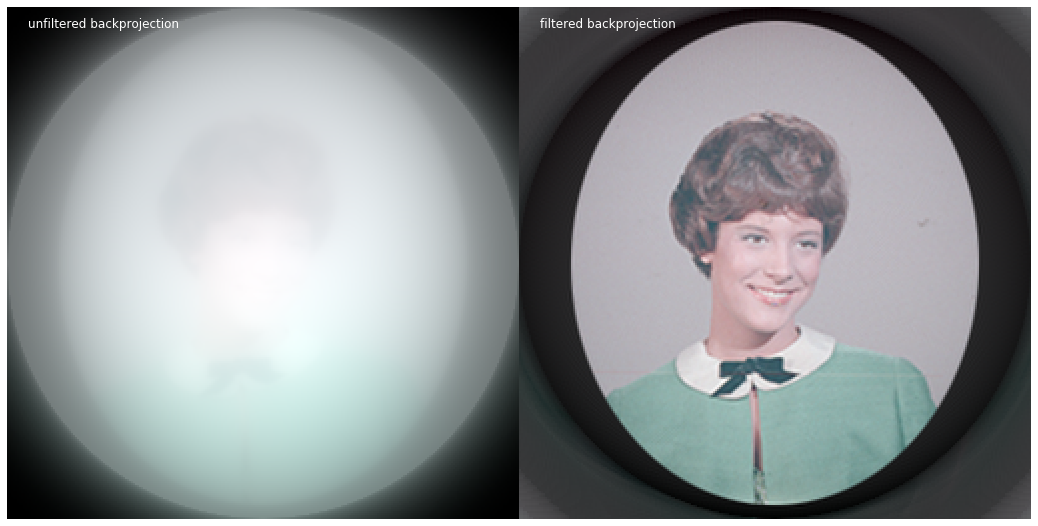

In [10]:
fig = plt.figure(figsize = (1024/72, 512/72))
gs = gridspec.GridSpec(1, 2)
gs.update(left = 0, right = 1, bottom = 0, top = 1, wspace = 0, hspace = 0)
axUnfiltered = plt.subplot(gs[0, 0]); axUnfiltered.axis('off')
axFiltered = plt.subplot(gs[0, 1]); axFiltered.axis('off')

axUnfiltered.imshow(unfiltered)
axFiltered.imshow(filtered)
axUnfiltered.text(10, 10, 'unfiltered backprojection', color = 'white', size = 12)
axFiltered.text(10, 10, 'filtered backprojection', color = 'white', size = 12)